# Tugas Prapraktikum

Tugas Prapraktikum dikerjakan dengan _dataset_ [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2). Tanpa meninjau waktu (`date`), prediksi status hujan pada keesokan harinya (`RainTomorrow`). Berikan nilai `1` jika diprediksi hujan pada keesokan harinya, `0` jika tidak.

<br>
Tugas dikerjakan secara berkelompok. Setiap kelompok terdiri atas 2 (dua) mahasiswa. Kumpulkan paling lambat pada Minggu, 16 April 2023, pukul 23:59 WIB melalui Edunex.

<br>

Oleh:

*   [13520138 - Gerald Abraham Sianturi](13520138@std.stei.itb.ac.id)
*   [13520162 - Daffa Romyz Aufa](13520162@std.stei.itb.ac.id)



# 0. Persiapan Data and Pustaka

In [268]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV

## Method to handle update with updated dataframe

In [269]:
def updateDataWithNewChange(df):
  X, y = df.drop(['RainTomorrow'], axis=1), df['RainTomorrow']
  features = list(X.columns)

  numericFeaturesDf = X.select_dtypes(include=['float64'])
  numericFeatures = list(numericFeaturesDf.columns)
  categoricalFeaturesDf = X.select_dtypes(include=['O'])
  categoricalFeatures = list(categoricalFeaturesDf.columns)

  return X, y, features, numericFeaturesDf, numericFeatures, categoricalFeaturesDf, categoricalFeatures

## Load dataset

In [270]:
df_with_date = pd.read_csv("../dataset/weatherAUS.csv")
df = df_with_date.iloc[:,1:]

X, y, features, numericFeaturesDf, numericFeatures, categoricalFeaturesDf, categoricalFeatures = updateDataWithNewChange(df);
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# I. Pemahaman Data
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal yang diliputi adalah sebagai berikut:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (_outlier_)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instansi dan fitur)
2. Tipe dari setiap fitur 
3. Banyak nilai unik dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

### I.1.1 Ukuran dari data

In [271]:
numOfRows, numOfCols = df.shape
print(f"Ukuran dari dataset: ")
print(f"\t- Number of rows: {numOfRows}")
print(f"\t- Number of columns: {numOfCols}")
print(f"\t\t- Features columns: {numOfCols - 1}")
print(f"\t\t- Target column: 1")

Ukuran dari dataset: 
	- Number of rows: 145460
	- Number of columns: 22
		- Features columns: 21
		- Target column: 1


### I.1.2 Tipe dari setiap fitur

In [272]:
features_dtype = X.dtypes
features_dtype

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
dtype: object

### I.1.3 Banyak nilai unik dari fitur yang bertipe kategorikal

In [273]:
X[categoricalFeatures].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

### I.1.4 Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

In [274]:
X[numericFeatures].applymap(lambda x: f"{x:0.2f}")

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.40,22.90,0.60,nan,nan,44.00,20.00,24.00,71.00,22.00,1007.70,1007.10,8.00,nan,16.90,21.80
1,7.40,25.10,0.00,nan,nan,44.00,4.00,22.00,44.00,25.00,1010.60,1007.80,nan,nan,17.20,24.30
2,12.90,25.70,0.00,nan,nan,46.00,19.00,26.00,38.00,30.00,1007.60,1008.70,nan,2.00,21.00,23.20
3,9.20,28.00,0.00,nan,nan,24.00,11.00,9.00,45.00,16.00,1017.60,1012.80,nan,nan,18.10,26.50
4,17.50,32.30,1.00,nan,nan,41.00,7.00,20.00,82.00,33.00,1010.80,1006.00,7.00,8.00,17.80,29.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.80,23.40,0.00,nan,nan,31.00,13.00,11.00,51.00,24.00,1024.60,1020.30,nan,nan,10.10,22.40
145456,3.60,25.30,0.00,nan,nan,22.00,13.00,9.00,56.00,21.00,1023.50,1019.10,nan,nan,10.90,24.50
145457,5.40,26.90,0.00,nan,nan,37.00,9.00,9.00,53.00,24.00,1021.00,1016.80,nan,nan,12.50,26.10
145458,7.80,27.00,0.00,nan,nan,28.00,13.00,7.00,51.00,24.00,1019.40,1016.50,3.00,2.00,15.10,26.00


## I.2
Carilah:
1. Nilai hilang (_missing_) dari setiap fitur
2. Nilai pencilan (_outlier_) dari setiap fitur

### I.2.1 Nilai hilang (_missing_) dari setiap fitur

In [275]:
listOfCountMissingVal = df.isna().sum().values
for i, col in enumerate(df):
  numOfMissingValue = listOfCountMissingVal[i]
  proportionOfMissingValue = round(numOfMissingValue / numOfRows * 100, 2)
  print(f"{col}: {numOfMissingValue} ({proportionOfMissingValue} %)")

Location: 0 (0.0 %)
MinTemp: 1485 (1.02 %)
MaxTemp: 1261 (0.87 %)
Rainfall: 3261 (2.24 %)
Evaporation: 62790 (43.17 %)
Sunshine: 69835 (48.01 %)
WindGustDir: 10326 (7.1 %)
WindGustSpeed: 10263 (7.06 %)
WindDir9am: 10566 (7.26 %)
WindDir3pm: 4228 (2.91 %)
WindSpeed9am: 1767 (1.21 %)
WindSpeed3pm: 3062 (2.11 %)
Humidity9am: 2654 (1.82 %)
Humidity3pm: 4507 (3.1 %)
Pressure9am: 15065 (10.36 %)
Pressure3pm: 15028 (10.33 %)
Cloud9am: 55888 (38.42 %)
Cloud3pm: 59358 (40.81 %)
Temp9am: 1767 (1.21 %)
Temp3pm: 3609 (2.48 %)
RainToday: 3261 (2.24 %)
RainTomorrow: 3267 (2.25 %)


<AxesSubplot:>

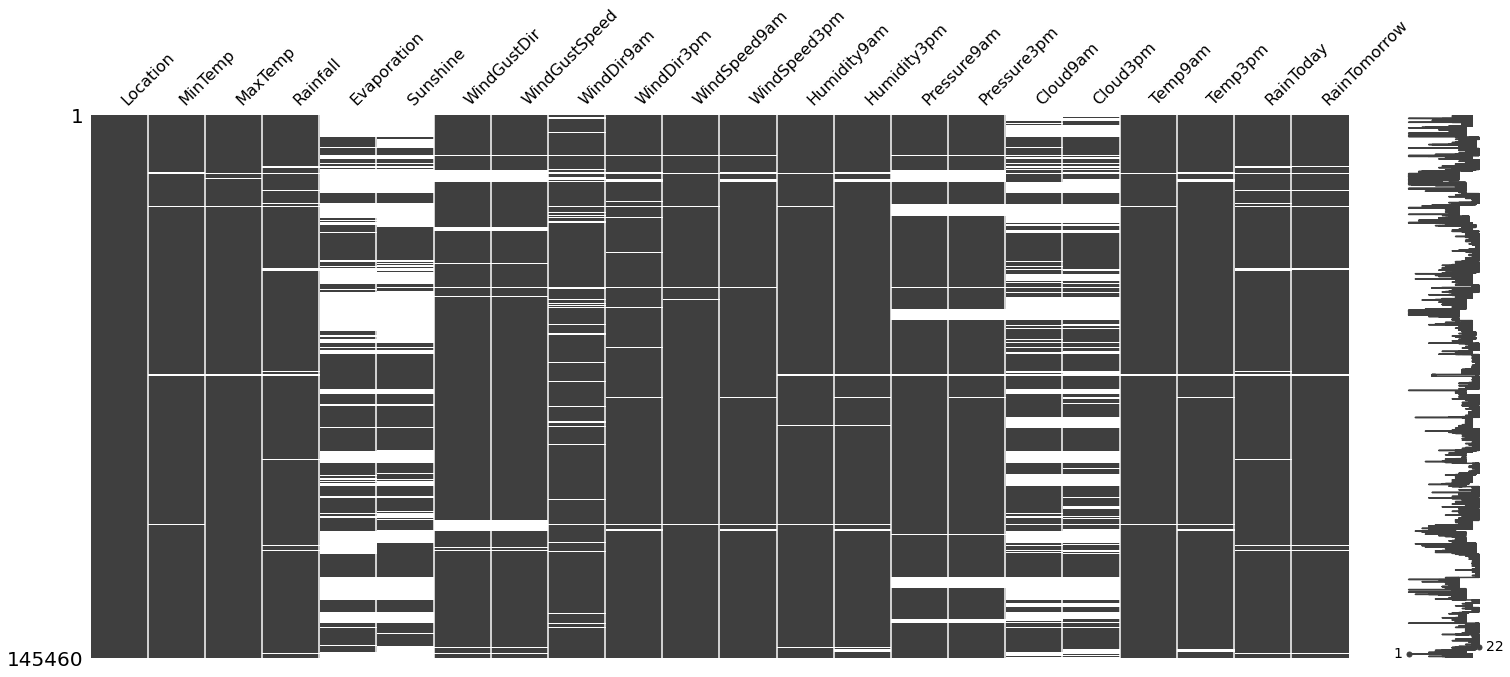

In [276]:
msno.matrix(df)

### I.2.2 Nilai pencilan (_outlier_) dari setiap fitur

In [277]:
# Variable for future use
numericFeatNoOutlier = []

for feature in numericFeatures:
  Q1 = X[feature].quantile(0.25)
  Q3 = X[feature].quantile(0.75)
  IQR = round(Q3 - Q1, 2)
  countOutlier = ((X[feature] < (Q1 - 1.5 * IQR)) | (X[feature] > (Q3 + 1.5 * IQR))).sum()
  print(f"{feature}: {countOutlier}")

  if(countOutlier == 0):
    numericFeatNoOutlier.append(feature)

MinTemp: 54
MaxTemp: 489
Rainfall: 25578
Evaporation: 1995
Sunshine: 0
WindGustSpeed: 3092
WindSpeed9am: 1817
WindSpeed3pm: 2523
Humidity9am: 1425
Humidity3pm: 0
Pressure9am: 1191
Pressure3pm: 919
Cloud9am: 0
Cloud3pm: 0
Temp9am: 262
Temp3pm: 731


## I.3
Lakukan:
1. Pencarian korelasi antarfitur
2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

### I.3.1 Pencarian korelasi antarfitur

<AxesSubplot:>

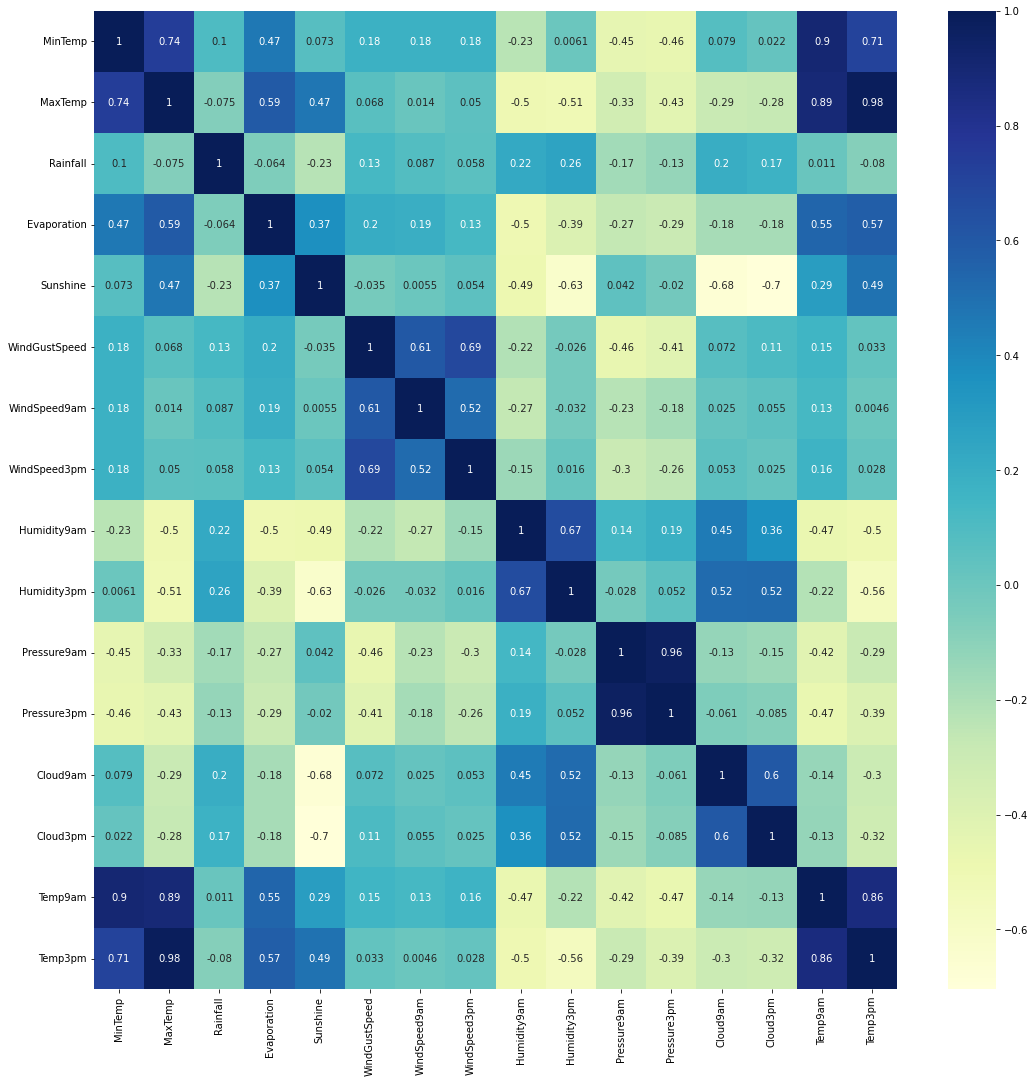

In [278]:
plt.subplots(figsize=(18,18))
sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)

### I.3.2 Visualisasi distribusi setiap fitur (kategorikal dan kontinu)

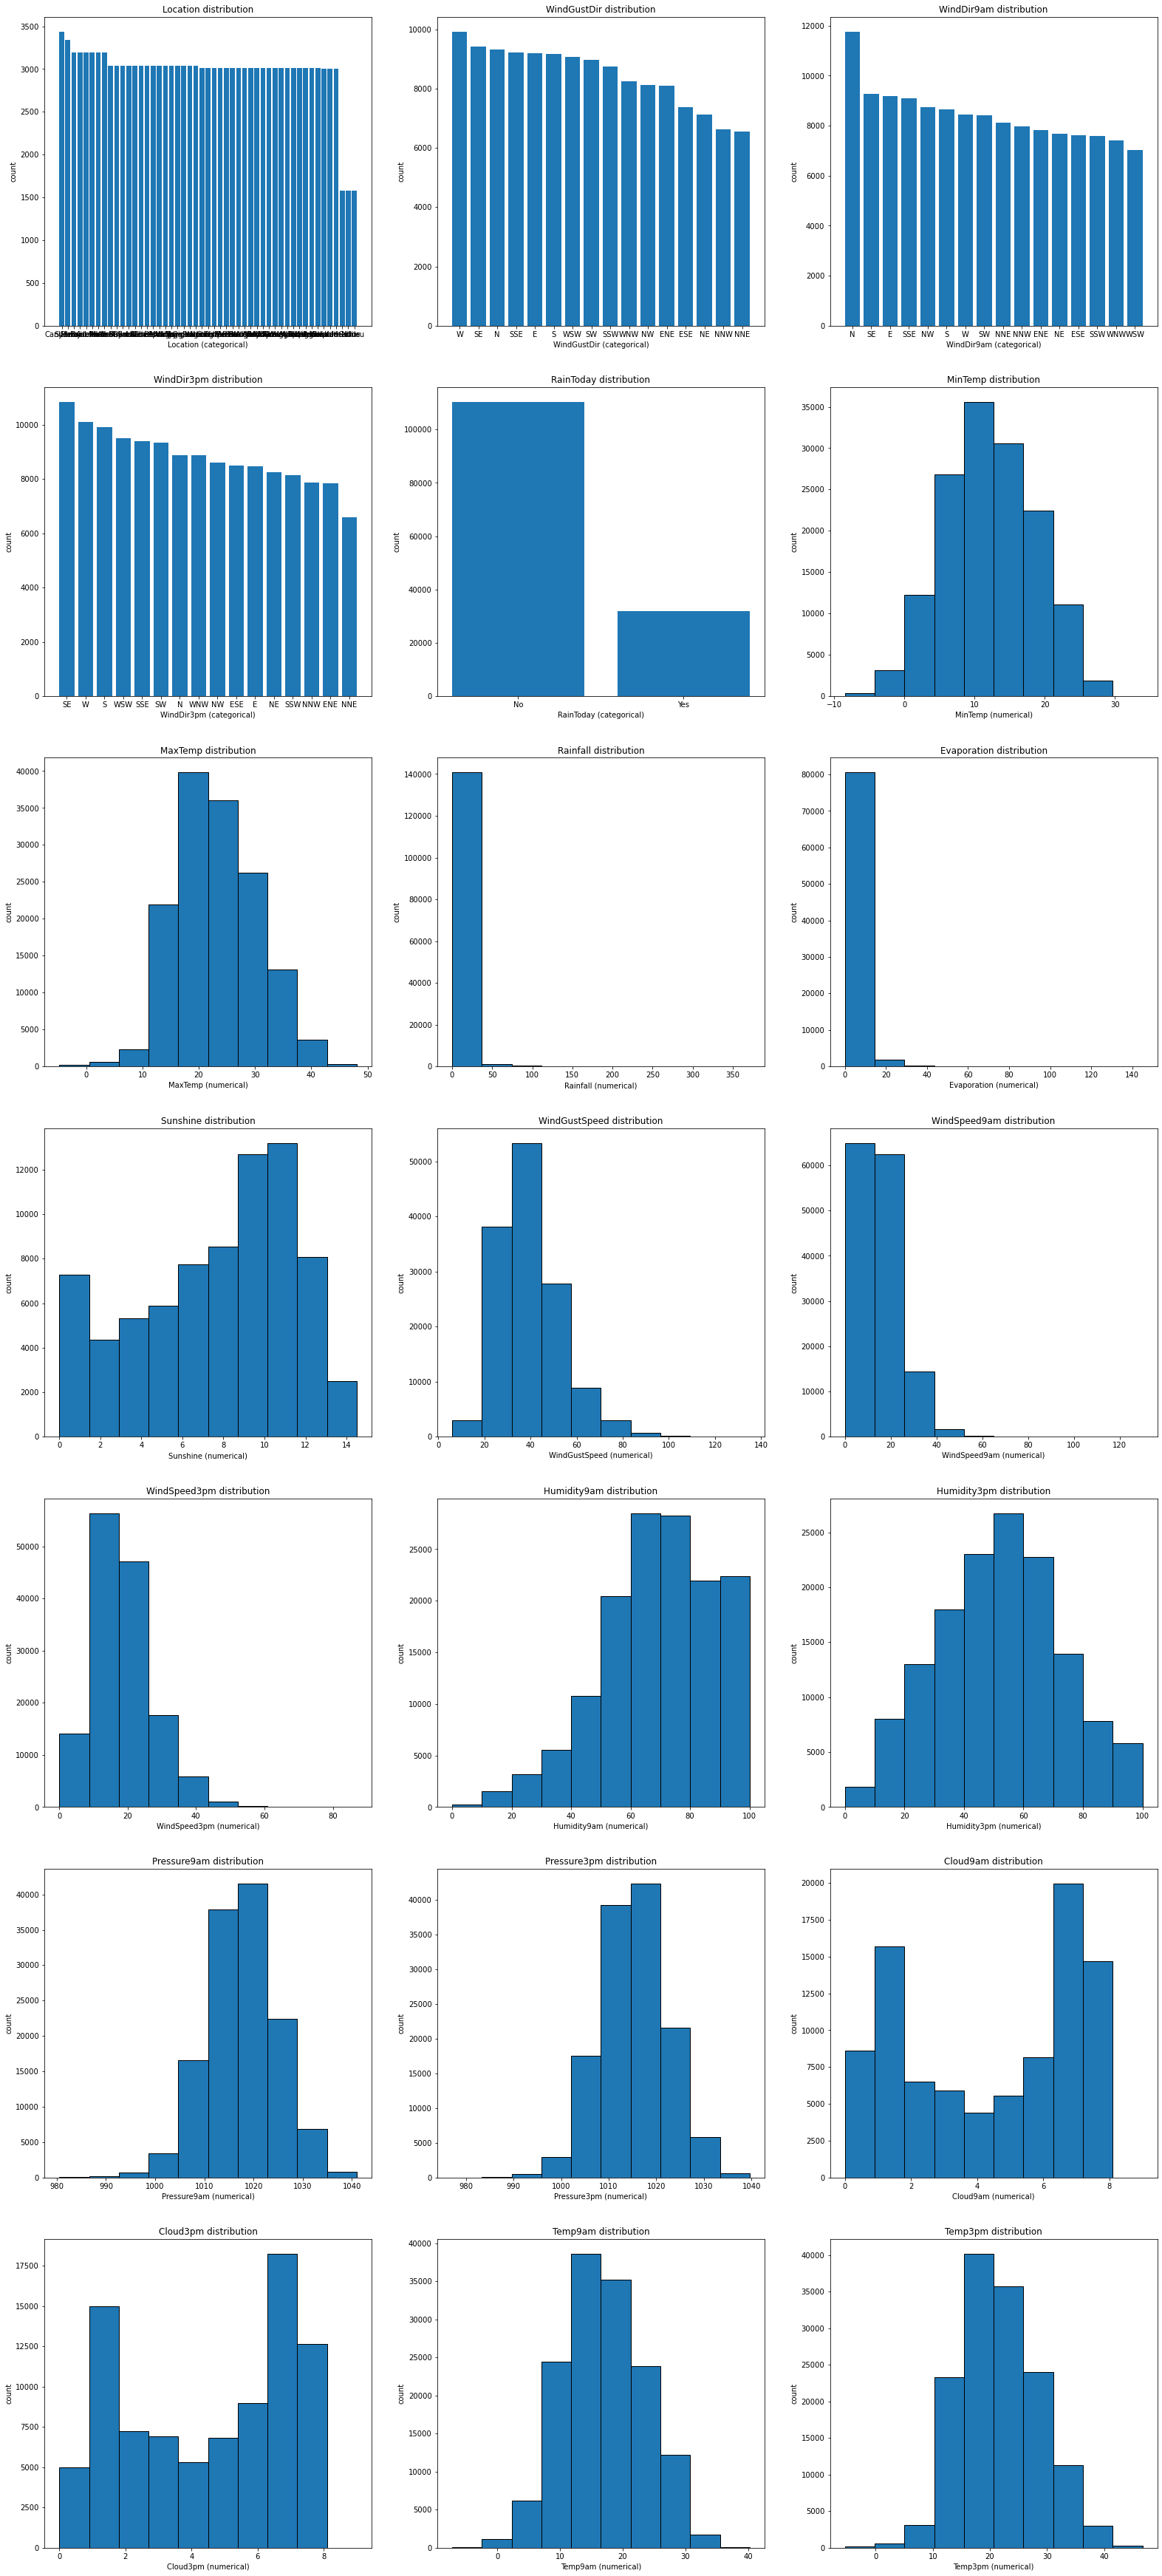

In [279]:
# Method to visualize all feature distribution based on its dataframe and list of categorical or numeric data feature
def visualizeDistribution(df, categoricalFeatures, numericFeatures, extraInformation = ""):
  fig, axs = plt.subplots(7, 3, figsize=(27, 63))
  i = 0
  j = 0
  for feature in categoricalFeatures:
    countData = df[feature].value_counts()
    axs[i][j].bar(countData.index, countData.values)
    axs[i][j].set_title(f"{feature} distribution")
    axs[i][j].set_xlabel(f"{feature} (categorical)")
    axs[i][j].set_ylabel(f"count{extraInformation}")

    j += 1
    if(j == 3):
      i += 1
      j = 0

  for feature in numericFeatures:
    axs[i][j].hist(df[feature], edgecolor = "black")
    axs[i][j].set_title(f"{feature} distribution")
    axs[i][j].set_xlabel(f"{feature} (numerical)")
    axs[i][j].set_ylabel(f"count{extraInformation}")

    j += 1
    if(j == 3):
      i += 1
      j = 0
  plt.show()

visualizeDistribution(df, categoricalFeatures, numericFeatures)


### I.3.3 Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

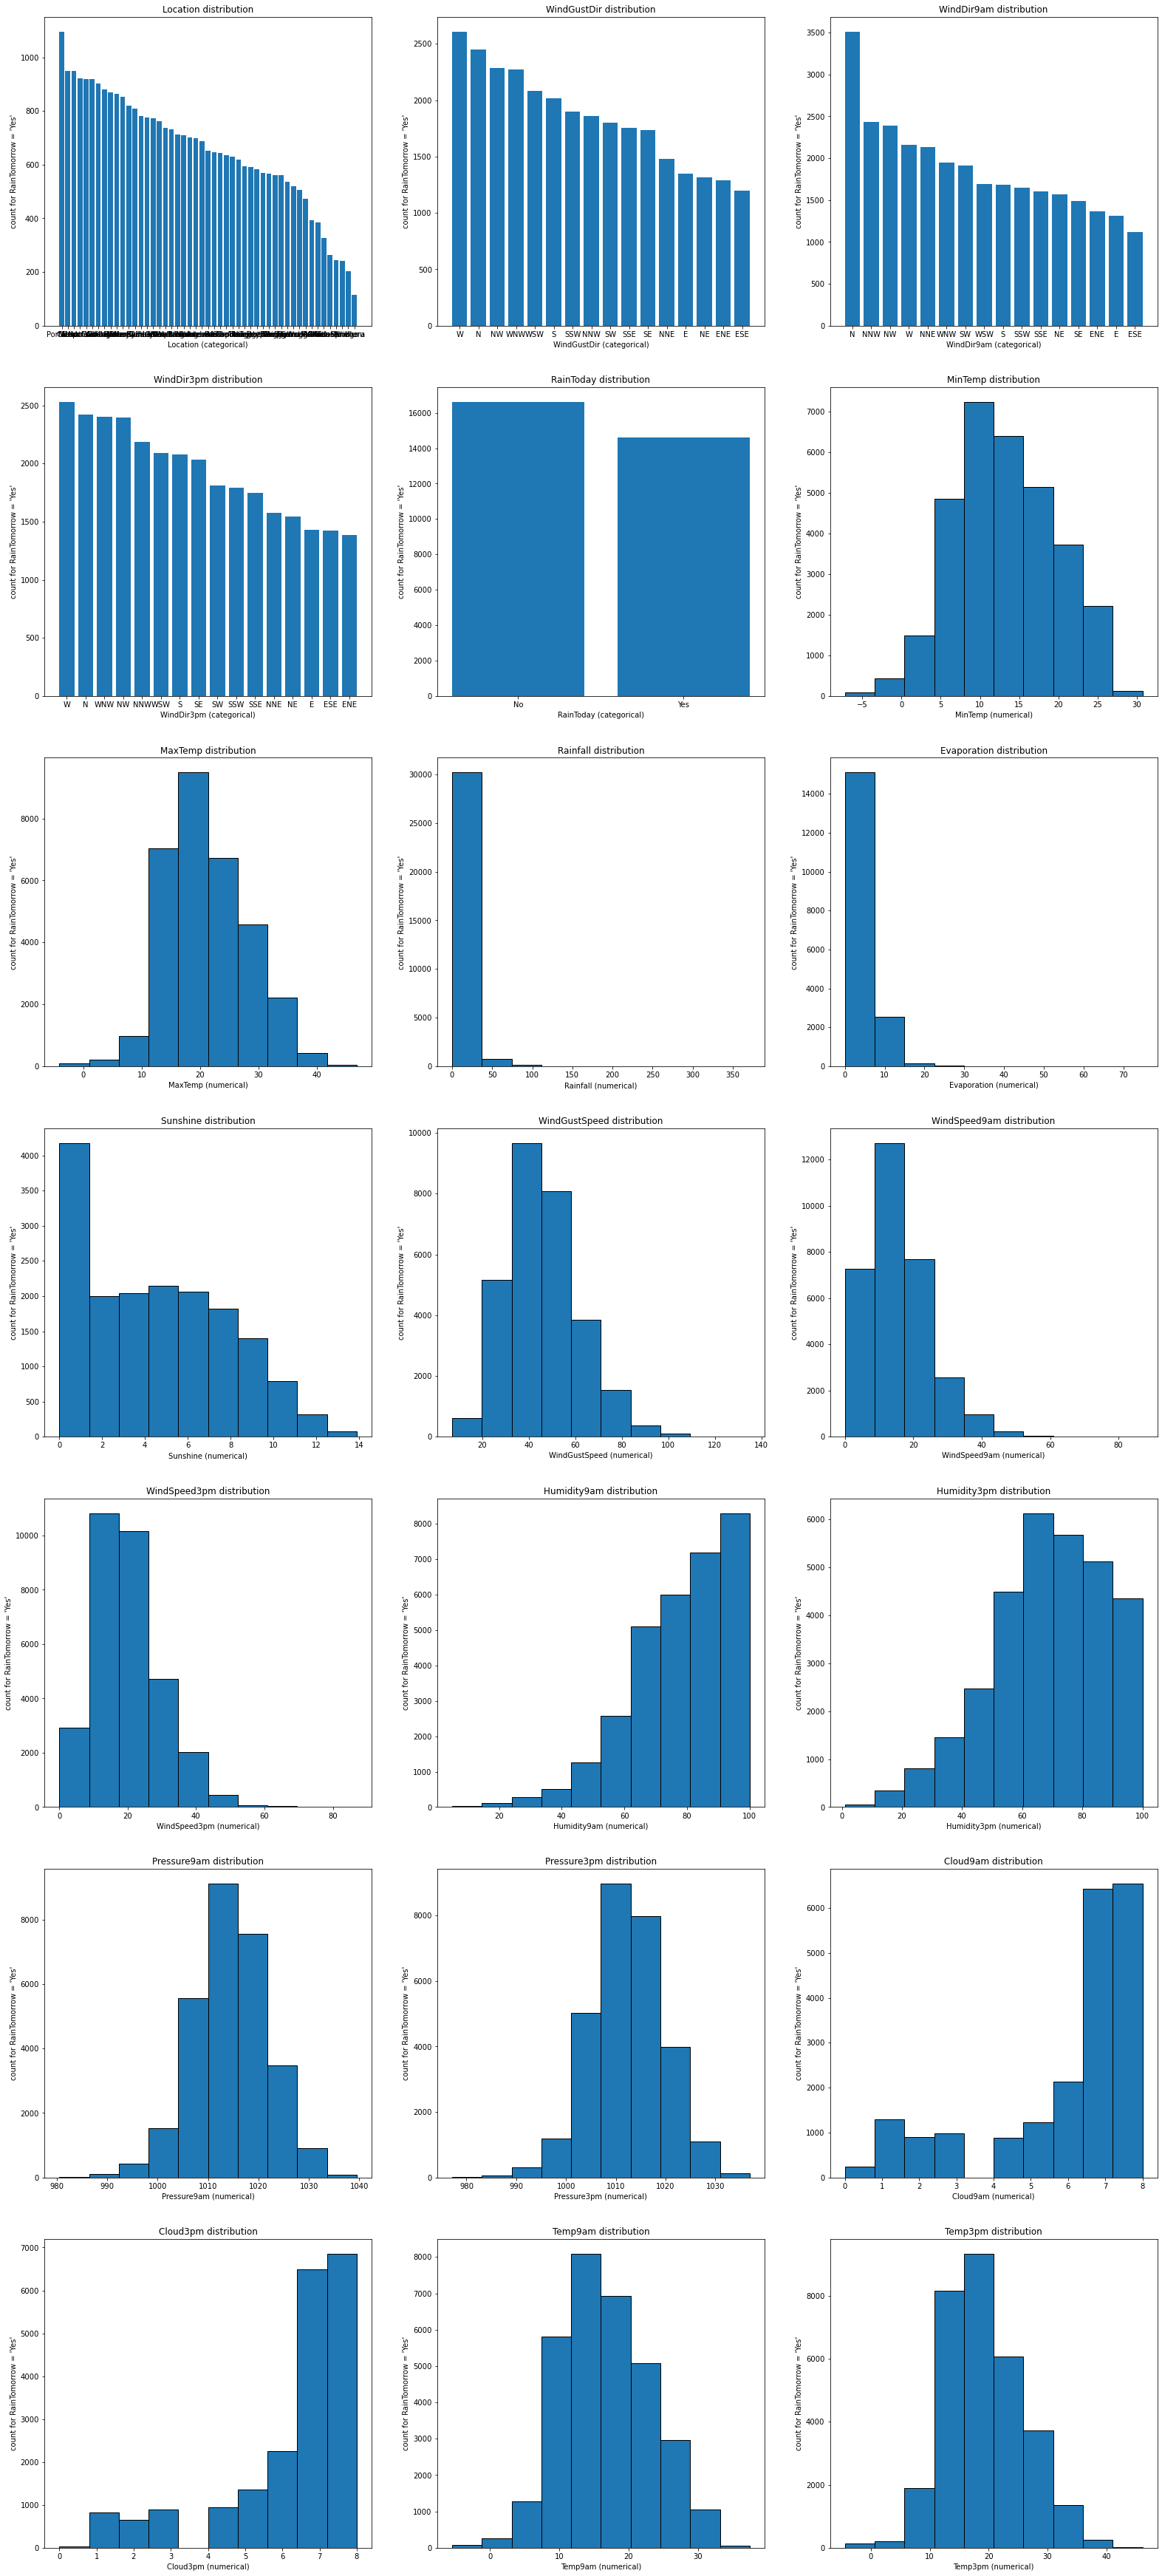

In [280]:
# Kasus Target = Yes
df_rain_tomorrow_yes = df[df['RainTomorrow'] == "Yes"]
visualizeDistribution(df_rain_tomorrow_yes, categoricalFeatures, numericFeatures, " for RainTomorrow = 'Yes'")

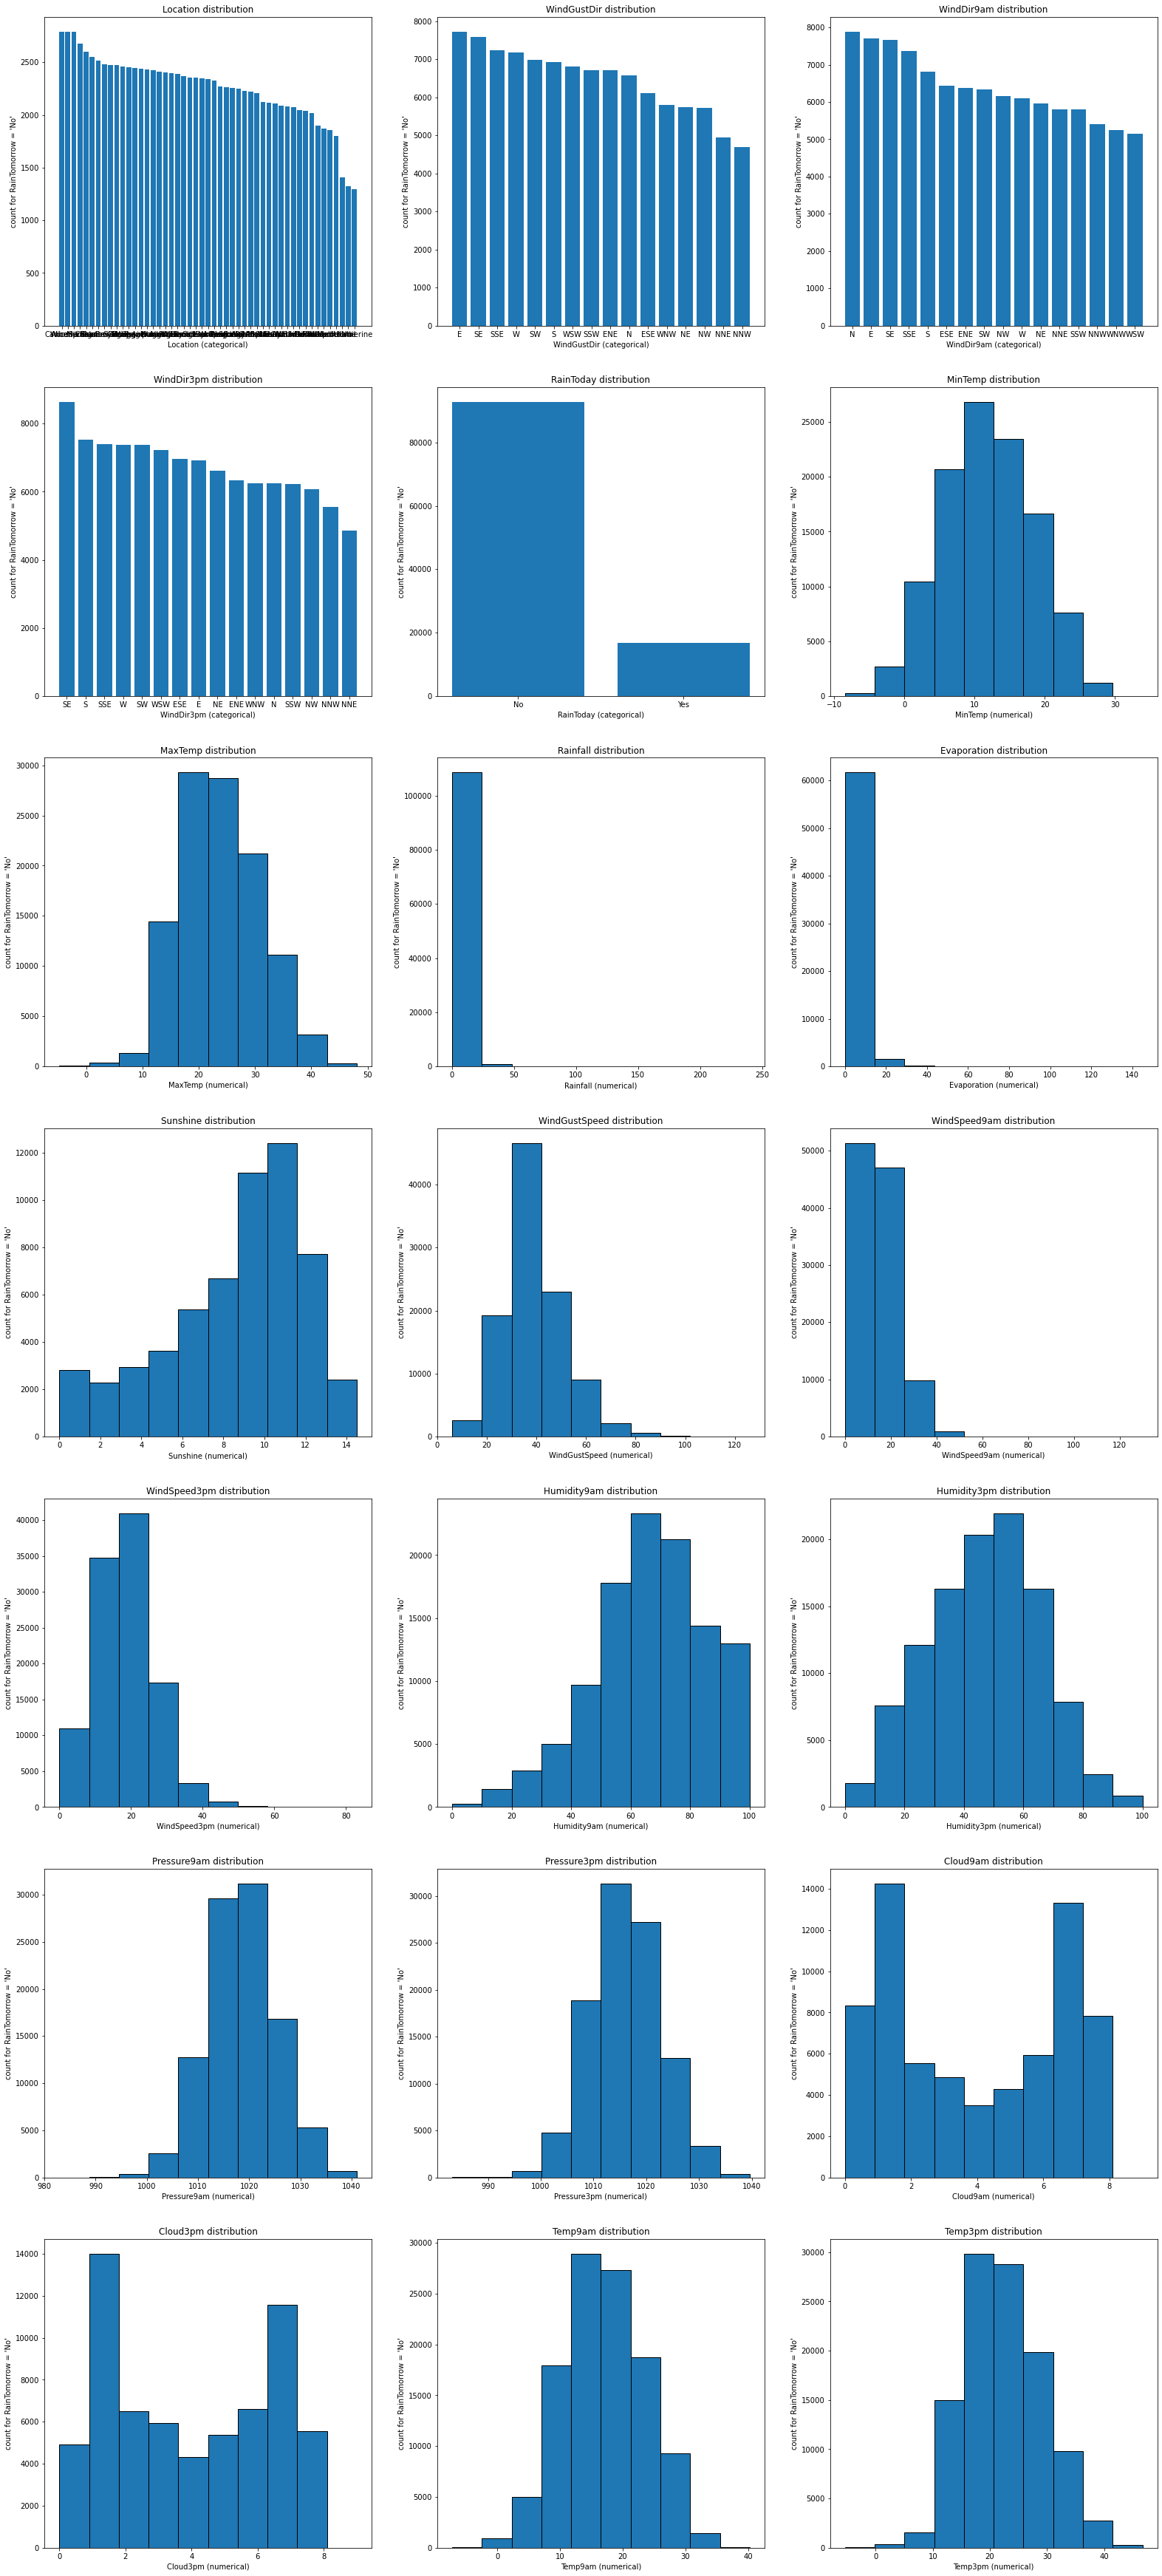

In [281]:
# Kasus Target = No
df_rain_tomorrow_no = df[df['RainTomorrow'] == "No"]
visualizeDistribution(df_rain_tomorrow_no, categoricalFeatures, numericFeatures, " for RainTomorrow = 'No'")

## I.4
Lakukanlah analisis lebih lanjut jika diperlukan, kemudian lakukan hal berikut:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan nilai hilang
4. Transformasi data kategorikal menjadi numerikal (_encoding_)
5. _Scaling_ dengan `MinMaxScaler`

### I.4.1 Penambahan fitur jika memungkinkan

In [282]:
df['WindSpeedDiff'] = df['WindSpeed9am'] - df['WindSpeed3pm']
df['HumidityDiff'] = df['Humidity9am'] - df['Humidity3pm']
df['PressureDiff'] = df['Pressure9am'] - df['Pressure3pm']
df['CloudDiff'] = df['Cloud9am'] - df['Cloud3pm']
df['TempDiff'] = df['Temp9am'] - df['Temp3pm']

X, y, features, numericFeaturesDf, numericFeatures, categoricalFeaturesDf, categoricalFeatures = updateDataWithNewChange(df)

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindSpeedDiff,HumidityDiff,PressureDiff,CloudDiff,TempDiff
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,NaN,16.9,21.8,No,No,-4.0,49.0,0.6,NaN,-4.9
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,NaN,17.2,24.3,No,No,-18.0,19.0,2.8,NaN,-7.1
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,2.0,21.0,23.2,No,No,-7.0,8.0,-1.1,NaN,-2.2
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,NaN,18.1,26.5,No,No,2.0,29.0,4.8,NaN,-8.4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,8.0,17.8,29.7,No,No,-13.0,49.0,4.8,-1.0,-11.9


### I.4.2 Pembuangan fitur yang menurut kalian tidak dibutuhkan

In [283]:
# Tidak ada fitur yang menurut kami tidak dibutuhkan

### I.4.3a Penanganan nilai hilang

In [284]:
for col in df.columns:
  # * Handling missing value in numerical features
  if col in numericFeatures:
    # ** In numerical features with no outlier, use means
    if(col in numericFeatNoOutlier):
      meanValue = round(X[col].mean(), 2)
      df[col].fillna(meanValue, inplace = True)
    else:
      medianValue = X[col].median()
      df[col].fillna(medianValue, inplace = True)
  elif col in categoricalFeatures:
    filler = df[col].value_counts().index[0]
    df[col].fillna(filler, inplace = True)

In [285]:
print("=== Number of missing value after handling it ===")
df.isna().sum()

=== Number of missing value after handling it ===


Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow     3267
WindSpeedDiff       0
HumidityDiff        0
PressureDiff        0
CloudDiff           0
TempDiff            0
dtype: int64

### I.4.4 Transformasi data kategorikal menjadi numerikal (_encoding_)

In [286]:
uniqueValueList = X.select_dtypes(include=['O']).nunique().values
uniqueValueDict = {}
for idx, val in enumerate(uniqueValueList):
  currentFeat = categoricalFeatures[idx]
  countUniqueVal = uniqueValueList[idx]

  listOfUniqueVal = df[currentFeat].unique()

  tempDict = {}
  for i, tempVal in enumerate(listOfUniqueVal):
    tempDict[tempVal] = i

  uniqueValueDict[currentFeat] = tempDict

In [287]:
df = df.replace(uniqueValueDict)
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

### I.4.3b. Penanganan nilai hilang (pada _target columns_)

In [288]:
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns = df.columns)

df.loc[df["RainTomorrow"] >= 0.5, "RainTomorrow"] = 1
df.loc[df["RainTomorrow"] < 0.5, "RainTomorrow"] = 0

In [289]:
X, y, features, numericFeaturesDf, numericFeatures, categoricalFeaturesDf, categoricalFeatures = updateDataWithNewChange(df)

### I.4.5. _Scaling_ dengan `MinMaxScaler`

In [290]:
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)

X = pd.DataFrame(X_scaler, columns = features)
df[features] = X

X, y, features, numericFeaturesDf, numericFeatures, categoricalFeaturesDf, categoricalFeatures = updateDataWithNewChange(df)

# II. Desain Eksperimen
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal yang diliputi adalah sebagai berikut:
1. Pembuatan model
2. Proses validasi
3. _Hyperparameter tuning_

## II.1
Tentukanlah metrik yang akan digunakan pada eksperimen kali ini. Metrik yang dapat lebih dari satu jenis.

1. Akurasi: mengukur proporsi dari prediksi yang benar terhadap total keseluruhan yang diprediksi.

2. Precision: mengukur proporsi prediksi true positive terhadap total positive prediction.

3. Recall: mengukur proporsi prediksi true positive terhadap total kasus positif pada dataset.

4. F1 score: rata-rata dari precision dan recall dengan memperhatikanbobot tertentu

## II.2 
Bagi data dengan perbandingan 0,8 untuk data latih dan 0,2 untuk data validasi.

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## II.3
Lakukan hal berikut:
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
3. Tampilkan _confusion matrix_.

### II.3.1 Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.

In [292]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

y_test_predict = logreg.predict(X_test)
y_train_predict = logreg.predict(X_train)

### II.3.2 Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1

In [293]:
def displayEvaluationMetric(y_test, y_test_predict, name_of_set: str, name_of_model: str):
  accuracyTestSet = accuracy_score(y_test, y_test_predict)
  precisionTestSet = precision_score(y_test, y_test_predict)
  recallTestSet = recall_score(y_test, y_test_predict)
  f1TestSet = f1_score(y_test, y_test_predict)

  print(f"=== Evaluation metric pada {name_of_set} set dengan {name_of_model} ===")
  print(f"Skor akurasi pada test set: {round(accuracyTestSet, 4)}")
  print(f"Skor precision pada test set: {round(precisionTestSet, 4)}")
  print(f"Skor recall pada test set: {round(recallTestSet, 4)}")
  print(f"Skor f1 pada test set: {round(f1TestSet, 4)}\n")

displayEvaluationMetric(y_test, y_test_predict, "test", "logistic regression")
displayEvaluationMetric(y_train, y_train_predict, "train", "logistic regression")

=== Evaluation metric pada test set dengan logistic regression ===
Skor akurasi pada test set: 0.8445
Skor precision pada test set: 0.7241
Skor recall pada test set: 0.4857
Skor f1 pada test set: 0.5814

=== Evaluation metric pada train set dengan logistic regression ===
Skor akurasi pada test set: 0.8443
Skor precision pada test set: 0.7219
Skor recall pada test set: 0.4912
Skor f1 pada test set: 0.5846



### II.3.3 Tampilkan _confusion matrix_

In [294]:
def displayConfusionMatrix(confMatrix):
  print(f"True Positives(TP) = {confMatrix[0,0]}")
  print(f"True Negatives(TN)  = {confMatrix[1,1]}")
  print(f"False Positives(FP) = {confMatrix[0,1]}")
  print(f"False Negatives(FN) = {confMatrix[1,0]}")

confMatrix1Test = confusion_matrix(y_test, y_test_predict)

displayConfusionMatrix(confMatrix1Test)


True Positives(TP) = 21428
True Negatives(TN)  = 3141
False Positives(FP) = 1197
False Negatives(FN) = 3326


#### Weight untuk tiap fitur

In [295]:
coefs = logreg.coef_[0]
coefs = [ round(coef, 2) for coef in coefs ]
for idx, feature in enumerate(features):
  print(f"{feature}: {coefs[idx]}")

Location: 0.07
MinTemp: -0.22
MaxTemp: -1.13
Rainfall: 2.85
Evaporation: -0.01
Sunshine: -1.7
WindGustDir: -0.11
WindGustSpeed: 6.5
WindDir9am: 0.15
WindDir3pm: -0.13
WindSpeed9am: -0.39
WindSpeed3pm: -2.47
Humidity9am: 3.48
Humidity3pm: 2.36
Pressure9am: -0.98
Pressure3pm: -2.78
Cloud9am: 0.45
Cloud3pm: 0.72
Temp9am: 0.7
Temp3pm: 0.94
RainToday: 0.55
WindSpeedDiff: -1.04
HumidityDiff: -5.61
PressureDiff: 3.93
CloudDiff: -1.05
TempDiff: 0.46


## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
3. Validasi dengan _cross validation_


### II.4.1 Pembelajaran dengan model lain (SVM)

In [296]:
svmModel = LinearSVC(random_state=0, tol=1e-5, dual = False)
svmModel.fit(X_train, y_train)

y_test_prediction_svm = svmModel.predict(X_test)
y_train_prediction_svm = svmModel.predict(X_train)

accuracyTestSet_svm = accuracy_score(y_test, y_test_prediction_svm)
accuracyTrainingSet_svm = accuracy_score(y_train, y_train_prediction_svm)

displayEvaluationMetric(y_test, y_test_prediction_svm, "test", "SVM")
displayEvaluationMetric(y_train, y_train_prediction_svm, "training", "SVM")

=== Evaluation metric pada test set dengan SVM ===
Skor akurasi pada test set: 0.8445
Skor precision pada test set: 0.7365
Skor recall pada test set: 0.4676
Skor f1 pada test set: 0.572

=== Evaluation metric pada training set dengan SVM ===
Skor akurasi pada test set: 0.8438
Skor precision pada test set: 0.733
Skor recall pada test set: 0.4715
Skor f1 pada test set: 0.5738



#### Bobot dari tiap fitur

In [297]:
coefs_svm = svmModel.coef_[0]
coefs_svm = [ round(coef, 2) for coef in coefs_svm ]
for idx, feature in enumerate(features):
  print(f"{feature}: {coefs_svm[idx]}")

Location: 0.03
MinTemp: -0.25
MaxTemp: -0.19
Rainfall: 1.53
Evaporation: 0.17
Sunshine: -0.59
WindGustDir: -0.02
WindGustSpeed: 2.23
WindDir9am: 0.05
WindDir3pm: -0.04
WindSpeed9am: 0.32
WindSpeed3pm: -1.19
Humidity9am: 1.21
Humidity3pm: 0.71
Pressure9am: -0.41
Pressure3pm: -0.85
Cloud9am: 0.12
Cloud3pm: 0.21
Temp9am: 0.1
Temp3pm: 0.44
RainToday: 0.19
WindSpeedDiff: -0.68
HumidityDiff: -2.19
PressureDiff: 1.37
CloudDiff: -0.3
TempDiff: 0.08


### II.4.2 _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)

In [298]:
listParam = {
  'C': [0.5, 1.0, 5.0],
  'loss': ['squared_hinge', 'hinge'],
}

svmVariant = GridSearchCV(svmModel, listParam)
svmVariant.fit(X_train, y_train)

c:\Users\geral\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\geral\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\geral\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\geral\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_cla

GridSearchCV(estimator=LinearSVC(dual=False, random_state=0, tol=1e-05),
             param_grid={'C': [0.5, 1.0, 5.0],
                         'loss': ['squared_hinge', 'hinge']})

#### Best parameter dan evaluasi metrik

In [299]:
print("=== Best Parameter ===")
print(svmVariant.best_params_, "\n")

print("=== Metrik Evaluasi ===")
svmVariant_pred = svmVariant.predict(X_test)
print(classification_report(y_test, svmVariant_pred)) 

=== Best Parameter ===
{'C': 1.0, 'loss': 'squared_hinge'} 

=== Metrik Evaluasi ===
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     22625
         1.0       0.74      0.47      0.57      6467

    accuracy                           0.84     29092
   macro avg       0.80      0.71      0.74     29092
weighted avg       0.83      0.84      0.83     29092



### II.4.3 Validasi dengan _cross validation_ (`k = 5`)

In [300]:
scores = cross_val_score(svmModel, X, y, cv=5).round(decimals=3)
print(scores)
print(f"Means: {round(scores.mean(), 3)}; standar deviasi: {round(scores.std(), 3)}")

[0.832 0.827 0.846 0.847 0.849]
Means: 0.84; standar deviasi: 0.009


# III. Improvement
Pada bagian ini, kalian diharapkan dapat:
1. melakukan pelatihan dengan data hasil _oversampling_ / _undersampling_, disertai dengan validasi yang benar; serta
2. menerapkan beberapa metode untuk menggabungkan beberapa model.

Kedua hal ini adalah contoh metode untuk meningkatkan kinerja dari model.

## III.1
Lakukanlah:
1. _Oversampling_ pada kelas minoritas pada data latih
2. _Undersampling_ pada kelas mayoritas pada data latih

Pada setiap tahap, latih dengan model *baseline* (II.3), dan validasi dengan data validasi. Data latih dan validasi adalah data yang disusun pada bagian II.2.

In [301]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
df = X_train.copy()
df["RainTomorrow"] = y_train
df_0 = df[df["RainTomorrow"] == 0]
df_1 = df[df["RainTomorrow"] == 1]
print( "class 0 = ", len(df_0), "; class 1 =", len(df_1))
df_mayor = df_1
df_minor = df_0
n_mayor = len(df_1)
n_minor = len(df_0)
if (len(df_0) > len(df_1)):
    df_mayor = df_0
    df_minor = df_1
    n_mayor = len(df_0)
    n_minor = len(df_1)

class 0 =  90408 ; class 1 = 25960


### III.1.1 _Oversampling_ pada kelas minoritas pada data latih

In [302]:
df_over = df_minor.sample(n_mayor, replace=True)
df_oversample = pd.concat([df_mayor, df_over])
X_OS_train = df_oversample.drop(columns=["RainTomorrow"])
y_OS_train = df_oversample["RainTomorrow"]
lr_OS = logreg.fit(X_OS_train, y_OS_train)
lr_OS_predict = lr_OS.predict(X_test)
displayEvaluationMetric(y_test, lr_OS_predict, "test", "oversampling")
      

=== Evaluation metric pada test set dengan oversampling ===
Skor akurasi pada test set: 0.7892
Skor precision pada test set: 0.5175
Skor recall pada test set: 0.7622
Skor f1 pada test set: 0.6164



### III.1.2 _Undersampling_ pada kelas mayoritas pada data latih

In [303]:

df_under = df_mayor.sample(n_minor)
df_undersample = pd.concat([df_under, df_minor])
X_US_train = df_undersample.drop(columns=["RainTomorrow"])
y_US_train = df_undersample["RainTomorrow"]
lr_US = logreg.fit(X_US_train, y_US_train)
lr_US_predict = lr_US.predict(X_test)
displayEvaluationMetric(y_test, lr_US_predict, "test", "undersampling")

=== Evaluation metric pada test set dengan undersampling ===
Skor akurasi pada test set: 0.7889
Skor precision pada test set: 0.5171
Skor recall pada test set: 0.7603
Skor f1 pada test set: 0.6156



## III.2
Lakukanlah:
1. Eksplorasi _soft voting_, _hard voting_, dan _stacking_.
2. Buatlah model _logistic regression_ dan SVM.
3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.
4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.
5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.
6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

### III.2.1 Eksplorasi _soft voting_, _hard voting_, dan _stacking_. 
Soft voting, hard voting, dan stacking menggabungkan beberapa model untuk menentukan kelas suatu data

Soft voting menentukan kelas dengan merata-ratakan probabilitas kelas suatu data yang didapat dari setiap model. Misalnya terdapat 3 model yang menghasilkan probabilitas 0.6, 0.7, dan 0.8 bahwa suatu data memiliki kelas 0. Maka dengan metode soft voting probabilitas data tersebut memiliki kelas 0 adalah (0.6 + 0.7 + 0.8)/2 = 0.7. Maka dari itu, data memiliki kelas 0 karena 0.7 > 0.5

Hard voting menentukan kelas dengan mencari kelas yang paling banyak muncul dari hasil prediksi masing-masing model. Misalnya terdapat 3 model yang memiliki hasil prediksi suatu data yaitu kelas 0, kelas 1, dan kelas 0. Maka data tersebut memiliki kelas 0 karena merupakan kelas yang paling banyak muncul dari setiap predisi masing-masing model.

Stacking menentukan kelas dengan menjadikan hasil prediksi masing-masing model sebagai input dari sebuah model final classifier. Model final classifier akan mengeluarkan hasil prediksi kelas sebuah data. Misalnya terdapat 3 model yang memiliki hasil prediksi suatu data yaitu kelas 0, kelas 1, dan kelas 0. Hasil prediksi tersebut akan dijadikan input model final classifier yang akan memprediksi kelas data tersebut.

### III.2.2. Buatlah model _logistic regression_ dan SVM.

In [304]:
clf_lr = LogisticRegression(solver='liblinear', random_state=0)
clf_svm = LinearSVC(random_state=0, tol=1e-5, dual = False)
clf_svm_calibrated = CalibratedClassifierCV(clf_svm) 

### III.2.3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.

In [305]:
soft_voting = VotingClassifier(estimators=[('lr', clf_lr), ('svm', clf_svm_calibrated)], voting='soft')
soft_voting = soft_voting.fit(X_train, y_train)
soft_voting.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

### III.2.4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.

In [306]:
hard_voting = VotingClassifier(estimators=[('lr', clf_lr), ('svm', clf_svm)], voting='hard')
hard_voting = hard_voting.fit(X_train, y_train)
hard_voting.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

### III.2.5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.

In [307]:
stacking = StackingClassifier(estimators=[('lr', clf_lr), ('svm', clf_svm)], final_estimator=LogisticRegression())
stacking = stacking.fit(X_train, y_train)
stacking.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

### III.2.6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

In [308]:
sv_predict = soft_voting.predict(X_test)
hv_predict = hard_voting.predict(X_test)
s_predict = stacking.predict(X_test)

displayEvaluationMetric(y_test, sv_predict, "test", "soft voting")
displayEvaluationMetric(y_test, hv_predict, "test", "hard voting")
displayEvaluationMetric(y_test, s_predict, "test", "stacking")

=== Evaluation metric pada test set dengan soft voting ===
Skor akurasi pada test set: 0.8445
Skor precision pada test set: 0.7238
Skor recall pada test set: 0.4855
Skor f1 pada test set: 0.5812

=== Evaluation metric pada test set dengan hard voting ===
Skor akurasi pada test set: 0.8444
Skor precision pada test set: 0.7378
Skor recall pada test set: 0.4656
Skor f1 pada test set: 0.5709

=== Evaluation metric pada test set dengan stacking ===
Skor akurasi pada test set: 0.8448
Skor precision pada test set: 0.7274
Skor recall pada test set: 0.4831
Skor f1 pada test set: 0.5806



# IV. Analisis
Bandingkan hasil dari hal-hal berikut:
1. Model _baseline_ (II.3)
2. Model lain (II.4)
3. Hasil _undersampling_
4. Hasil _oversampling_
5. Hasil _soft voting_
6. Hasil _hard voting_
7. Hasil _stacking_

| Model          | Accuracy       | Precision      | Recall           | F1 score       |
| -------------- | -------------- | -------------- | -------------- | -------------- |
| Logstic regression | 0.8445         | 0.7241         | 0.4857         | 0.5814            |
| SVM            | 0.8445         | 0.7365         | 0.4676         | 0.572            |
| _Undersampling_| 0.7906         | 0.5198         | 0.7617         | 0.6179            |
| _Oversampling_ | 0.7897        | 0.5183         | 0.7640         | 0.6176            |
| _Soft voting_  | 0.8444         | 0.7238         | 0.4855         | 0.5812            |
| _Hard voting_  | 0.8444         | 0.7378         | 0.4655         | 0.5709            |
| Stacking       | 0.8448         | 0.7273         | 0.4830         | 0.5805            |

## Summary

Berdasarkan hasil metrik evaluasi pada model yang dibuat, model yang menggunakan logistic regression dan SVM tiadk memiliki perbedaan akurasi yang signifikan. Keduanya memiliki akurasi yang cukup tinggi yang mana mengindikasikan keduanya memiliki performa yang baik dalam memprediksi target variable (`RainTomorrow`).

Untuk metrik _precision_, model dengan SVM memiliki nilai yang sedikit lebih tinggi menunjukkan bahwa model ini lebih baik dalam memprediksi _positive cases_ dibandingkan dengan logistic regression. Sedangkan untuk nilai recall, berlaku sebaliknya dimana pada model dengan logistic regression yang sedikit lebih baik dalam memprediksi _actual positive cases_. Dengan demikian, dengan memperhatikan _trade-off_ antara kedua metrik ini, logistic regression lebih cocok digunakan karena _cost_ dari false negative, yakni `RainTomorrow` sebenarnya bernilai `True` tetapi prediksinya `False` (nilai _recall_), seperti tidak membawa payung ketika sebenaranya hujan, akan jauh lebih diperhatikan.

Model undersampling dan oversampling memiliki accuracy dan precision yang lebih rendah dibandingkan model lainya. Namun, kedua model memiliki nilai recall dan f1 yang lebh besar dari model lainya. Hal ini dikarenakan metode oversampling dan undersampling digunakan agar dapat memprediksi kelas minoritas yang benar. Maka dari itu nilai f1 lebih diutamakan

Model yang menggunakan penggabungan model-model seperti soft voting, hard voting, dan stacking memiliki nilai metrik yang sama dengan model linear regression dan SVM. Model soft voting, hard voting, dan stacking menggunakan model linear regression dan SVM sehingga memiliki nilai metrik yang mirip.

Model hard voting memiliki nilai precision yang lebih tinggi dari model soft voting dan stacking. Namun, memiliki nilai recall dan f1 yang lebih rendah. Hard voting menyamakan bobot prediksi setiap model padahal model tertentu dapat memiliki prediksi yang lebih baik dibanding model lain sehingga memiliki bobot yang lebih besar. Soft voting dan stacking memungkinkan prediksi yang lebih menyeluruh karena memperhitungkan probabilitas prediksi setiap model.